In [1]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm # linear regression
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from DE_GO_analysis import analyze_pla_marker_with_gsea_and_volcano_new
import scanpy as sc
from gprofiler import GProfiler
import os


#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2025)
random.seed(2025)

In [2]:
# Load the .h5ad file
adata_rna_gc_follicle = sc.read("combined_GC_follicle_mRNA_ABD.h5ad")
adata_fraction_oeverlap_gc_follicle = sc.read("adata_fraction_oeverlap_gc_follicle_for_GSEA.h5ad")

In [3]:
def plot_top_gsea_pos_neg(
    gsea_df,
    fdr_cutoff=0.25,
    top_n=5,
    figsize=(8, 3),
    output_path=None,
    title="Top GSEA Pathways by NES (FDR < 0.25)"
):
    """
    Plot top GSEA pathways with highest and lowest NES, filtered by FDR.

    Parameters:
        gsea_df (pd.DataFrame): GSEA results containing 'nes' and 'fdr' columns.
        fdr_cutoff (float): FDR threshold for significance filtering.
        top_n (int): Number of top positive and negative NES terms to display.
        figsize (tuple): Size of the plot (width, height).
        output_path (str): Optional path to save the plot.
        title (str): Title for the plot.
    """
    # Filter by FDR
    sig_df = gsea_df[gsea_df['fdr'] < fdr_cutoff].copy()
    if sig_df.empty:
        print("⚠️ No significant GSEA terms found (FDR < threshold).")
        return

    # Sort and select top positive and negative NES terms
    pos_terms = sig_df[sig_df['nes'] > 0].sort_values('nes', ascending=False).head(top_n)
    neg_terms = sig_df[sig_df['nes'] < 0].sort_values('nes', ascending=True).head(top_n)

    plot_df = pd.concat([pos_terms, neg_terms])
    plot_df["Term"] = plot_df.index

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(
        data=plot_df,
        x="nes",
        y="Term",
        palette=["red" if v > 0 else "blue" for v in plot_df["nes"]],
        ax=ax
    )

    # Annotate FDR values
    for i, (nes, fdr) in enumerate(zip(plot_df["nes"], plot_df["fdr"])):
        ax.text(
            nes + 0.05 if nes > 0 else nes - 0.05,
            i,
            f"FDR={fdr:.3f}",
            va="center",
            ha="left" if nes > 0 else "right",
            fontsize=8
        )

    # Aesthetic
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlabel("Normalized Enrichment Score (NES)")
    ax.set_ylabel("Pathway")
    ax.set_title(title)
    ax.margins(x=0.15)

    # Save or show
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches='tight', pad_inches=0.2)
        print(f"✅ Plot saved to: {output_path}")
    else:
        plt.tight_layout()
        plt.show()
        # Always also save to default location
        os.makedirs("Figures", exist_ok=True)
        default_path = os.path.join("Figures", "top_gsea_pos_neg.png")
        fig.savefig(default_path, dpi=300, bbox_inches='tight', pad_inches=0.2)
        print(f"✅ Plot also saved to: {default_path}")


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
from matplotlib.patches import Patch

def plot_deg_heatmap_from_df(
    deg_df,
    adata_rna,
    top_n=50,
    group_key='mrna_annotation',
    scale=True,
    cell_level=False,
    figsize=(4, 6),
    title=None,
    cmap='bwr',
    center=0,
    zscore_range=(-2, 2),
    group_palette=None,
    batch_key='batch',
    save_path=None
):
    """
    Plot a heatmap of top DEGs across groups or single cells, with cleanly arranged legends
    and an automatically adjusted colorbar.
    """

    # 1. Select top upregulated and downregulated genes
    up_genes = deg_df[(deg_df['logfoldchanges'] > 0) & (deg_df['pvals_adj'] < 0.05)]
    down_genes = deg_df[(deg_df['logfoldchanges'] < 0) & (deg_df['pvals_adj'] < 0.05)]
    top_up = up_genes.sort_values('pvals_adj').head(top_n)['names'].tolist()
    top_down = down_genes.sort_values('pvals_adj').head(top_n)['names'].tolist()
    gene_list = top_up + top_down

    if len(gene_list) == 0:
        print("⚠️ No significant DEGs found.")
        return

    # 2. Extract expression matrix
    if adata_rna.raw is not None:
        expr = adata_rna.raw[:, gene_list].X
    else:
        expr = adata_rna[:, gene_list].X
    if scipy.sparse.issparse(expr):
        expr = expr.toarray()

    expr_df = pd.DataFrame(expr, index=adata_rna.obs_names, columns=gene_list)
    obs_df = adata_rna.obs.copy()

    if cell_level:
        # 3a. Cell-level data
        obs_df = obs_df.sort_values(group_key)
        expr_df = expr_df.loc[obs_df.index]
        data_matrix = expr_df.T

        # Color bars
        group_series = obs_df[group_key].astype(str)
        batch_series = obs_df[batch_key].astype(str)

        group_values = group_series.unique().tolist()
        batch_values = batch_series.unique().tolist()

        if group_palette is None:
            group_palette = dict(zip(group_values, sns.color_palette("Set1", len(group_values))))
        batch_palette = dict(zip(batch_values, sns.color_palette("Pastel1", len(batch_values))))

        col_colors = pd.DataFrame({
            'Group': group_series.map(group_palette),
            'Batch': batch_series.map(batch_palette)
        }, index=obs_df.index)

    else:
        # 3b. Group-mean matrix
        expr_df[group_key] = obs_df[group_key]
        data_matrix = expr_df.groupby(group_key).mean().T
        col_colors = None

    # 4. Z-score normalization
    if scale:
        data_matrix = data_matrix.subtract(data_matrix.mean(axis=1), axis=0)
        data_matrix = data_matrix.divide(data_matrix.std(axis=1) + 1e-9, axis=0)
    if zscore_range:
        data_matrix = data_matrix.clip(lower=zscore_range[0], upper=zscore_range[1])

    # Show gene names only if <=20
    show_gene_labels = len(data_matrix.index) <= 20

    # 5. Plot heatmap
    if cell_level:
        cg = sns.clustermap(
            data_matrix,
            row_cluster=False,
            col_cluster=False,
            col_colors=col_colors,
            cmap=cmap,
            center=center,
            xticklabels=False,
            yticklabels=show_gene_labels,
            figsize=figsize,
            cbar_kws={'orientation': 'horizontal', 'label': 'Z-score' if scale else 'Expression'},
        )

    
        # Remove default colorbar
        cg.cax.set_visible(False)

        # Create a new colorbar axis manually
        cbar_ax = cg.fig.add_axes([0.92, 0.2, 0.02, 0.3])  # [x0, y0, width, height]
        norm = plt.Normalize(vmin=data_matrix.values.min(), vmax=data_matrix.values.max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = cg.fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
        cbar.set_label('Z-score' if scale else 'Expression')
      

        # Set the heatmap title
        cg.ax_heatmap.set_title(title or f"Top {top_n*2} DEGs (Single cell)",
                                fontsize=12, pad=15)

        # Legends: Move closer to the heatmap
        group_handles = [Patch(facecolor=group_palette[g], label=g) for g in group_palette]
        batch_handles = [Patch(facecolor=batch_palette[b], label=b) for b in batch_palette]

        
        
        cg.fig.legend(handles=group_handles, title=group_key, loc='upper center',
                      bbox_to_anchor=(0.55, 0.78), ncol=len(group_handles), frameon=False)
        cg.fig.legend(handles=batch_handles, title='Batch', loc='upper center',
                      bbox_to_anchor=(0.55, 0.85), ncol=len(batch_handles), frameon=False)

        cg.fig.subplots_adjust(top=0.80)  # Give space for legends

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Heatmap saved to {save_path}")
            plt.show()
        else:
            plt.show()

    else:
        # Group-average heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(
            data_matrix,
            cmap=cmap,
            center=center,
            linewidths=0,
            cbar_kws={'orientation': 'horizontal', 'label': 'Z-score' if scale else 'Expression'},
            xticklabels=True,
            yticklabels=show_gene_labels
        )
        plt.xlabel("Group")
        plt.ylabel("Gene" if show_gene_labels else "")
        plt.title(title or f"Top {top_n*2} DEGs across groups")
        plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for horizontal colorbar

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Heatmap saved to {save_path}")
            plt.close()
        else:
            plt.show()


[INFO] Filtering by batch: ['A1', 'B1']
adata_pla shape after filtering: (2599, 528)
adata_rna shape after filtering: (2849, 21398)
[INFO] PLA marker: ITGA4:VCAM1 | Clusters: ['Light zone', 'Dark zone']
High group: 130 cells | Low group: 130 cells
[INFO] Batch distribution for high group:
B1    80
A1    50
Name: batch, dtype: int64
[INFO] Batch distribution for low group:
A1    78
B1    52
Name: batch, dtype: int64
✅ Batch distribution plot saved to gsea_output/ITGA4_VCAM1_GC/ITGA4_VCAM1_GC_batch_distribution.svg


<Figure size 250x250 with 0 Axes>

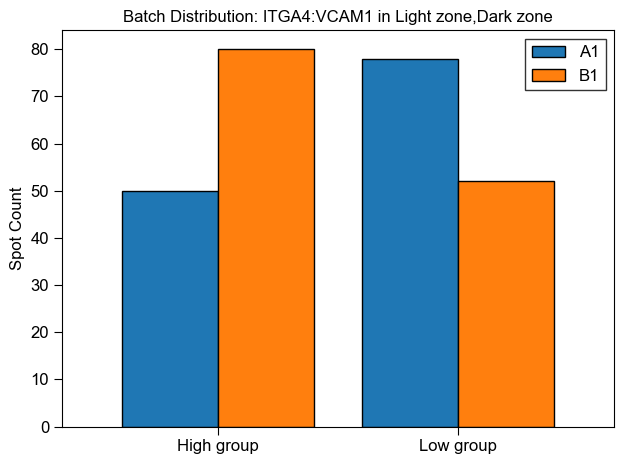

/Users/huiliw/Desktop/postdoc /spatial_visium/data/sequencing_data/2502_spatial_sequencing/20250228/analyze_pla_marker_with_gsea_and_volcano_new.py:124: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_high.concatenate(


=== Top Upregulated Pathways (NES > 0) ===

=== Top Downregulated Pathways (NES < 0) ===
✅ Volcano plot saved to gsea_output/ITGA4_VCAM1_GC/ITGA4_VCAM1_GC_volcano.svg


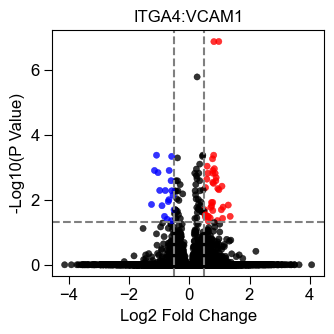

In [5]:
ITGA4_VCAM1_GC_results = analyze_pla_marker_with_gsea_and_volcano_new(
    adata_pla=adata_fraction_oeverlap_gc_follicle,
    adata_rna=adata_rna_gc_follicle,
    pla_marker="ITGA4:VCAM1",
    # cluster_labels="Dark zone",
    low_pct=10,
    high_pct=10,
    min_cells=30,
    cluster_key="mrna_annotation",
    gene_set_path = "c2.cp.v2025.1.Hs.symbols.gmt",
    # gene_set_path="c7.all.v2025.1.Hs.symbols.gmt",
    fc_thresh=0.5,
    top_n_terms=0,
    batch_filter=['A1','B1',],
    cluster_labels=["Light zone",'Dark zone' ],
    output_prefix="ITGA4_VCAM1_GC"
)

✅ Heatmap saved to Figures/Fig-6g.svg


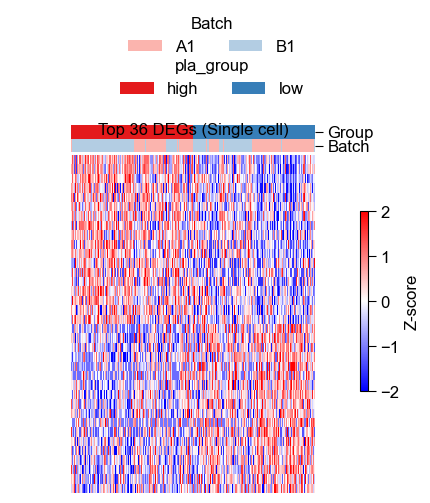

In [7]:
plot_deg_heatmap_from_df(
    deg_df=ITGA4_VCAM1_GC_results['deg_df'],
    adata_rna=ITGA4_VCAM1_GC_results['adata_combined'],
    group_key='pla_group',
    cell_level=True,
    top_n=18,
    scale=True,
    zscore_range=(-2, 2),
      save_path='Figures/Fig-6g.svg'
)



In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
import gseapy as gp

def run_enrichment_for_gene_sets(gene_sets_dict, gene_set_library="KEGG_2021_Human", output_dir="enrichr_output"):
    """
    Run Enrichr-based pathway enrichment using gseapy for multiple gene sets.
    """
    os.makedirs(output_dir, exist_ok=True)
    enrichment_results = {}

    for name, gene_list in gene_sets_dict.items():
        if not gene_list:
            print(f"⚠️ Skipping {name}: gene list is empty.")
            continue
        print(f"🔍 Running enrichment for: {name} (n={len(gene_list)})")
        try:
            enr = gp.enrichr(
                gene_list=list(gene_list),
                gene_sets=gene_set_library,
                organism="Human",
                outdir=os.path.join(output_dir, name),
                no_plot=True,
                cutoff=0.5
            )
            enrichment_results[name] = enr.results
        except Exception as e:
            print(f"❌ Failed on {name}: {e}")
    
    return enrichment_results

def plot_enrichment_bubble(df, label='Up_overlap', top_n=20, min_intersect_size=1, save_path=None):
    """
    Plot an enrichment bubble chart with fixed bubble size (no Intersection legend).

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing enrichment results with columns ['Term', 'Overlap', 'Adjusted P-value'].
    label : str
        Label for the plot title.
    top_n : int
        Number of top terms to display.
    min_intersect_size : int
        Minimum intersection size to include in the plot.
    save_path : str or None
        File path to save the figure (e.g., 'plot.png'). If None, the plot is only displayed.
    """
    required_cols = ['Term', 'Overlap', 'Adjusted P-value']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    if df.empty:
        print(f"⚠️ No enrichment results to plot for {label}")
        return

    # Parse intersection size and term size from the "Overlap" column
    try:
        df[['intersect_size', 'term_size']] = df['Overlap'].str.split('/', expand=True).astype(int)
    except Exception as e:
        raise ValueError(f"❌ Failed to parse 'Overlap' column: {e}")
    
    # Calculate Gene Ratio and -log10(Adjusted P-value)
    df['GeneRatio'] = df['intersect_size'] / df['term_size']
    df['neg_log10_p'] = -np.log10(df['Adjusted P-value'] + 1e-300)

    # Apply filters
    df = df[df['intersect_size'] >= min_intersect_size]
    df = df.sort_values('neg_log10_p', ascending=False).head(top_n).copy()
    if df.empty:
        print(f"⚠️ No terms passed filtering for {label}")
        return

    df['y_order'] = np.arange(len(df))

    # Create the figure
    plt.figure(figsize=(6, 3.5))
    norm = Normalize(vmin=df['neg_log10_p'].min(), vmax=df['neg_log10_p'].max())
    sm = ScalarMappable(cmap='RdBu_r', norm=norm)
    sm.set_array([])

    ax = plt.gca()

    # Scatter plot with fixed bubble size
    sns.scatterplot(
        data=df,
        x='GeneRatio',
        y='y_order',
        s=100,  # Fixed bubble size
        hue='neg_log10_p',
        palette='RdBu_r',
        edgecolor='black',
        linewidth=0.5,
        legend=False,  # No Intersection legend
        ax=ax
    )

    # Y-axis labels
    ax.set_yticks(df['y_order'])
    ax.set_yticklabels(df['Term'])
    ax.invert_yaxis()

    # Colorbar for p-values
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('-log10(Adjusted P-value)')

    # Axis labels and title
    plt.xlabel('Gene Ratio')
    plt.ylabel('Enriched Term')
    plt.title(f'Enrichment Bubble Plot – {label}')

    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Save figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Bubble plot saved to {save_path}")

    plt.show()




In [14]:
deg_df = ITGA4_VCAM1_GC_results['deg_df']

In [15]:
up_genes = deg_df[(deg_df['logfoldchanges'] > 0.5) & (deg_df['pvals_adj'] < 0.05)]['names'].tolist()
down_genes = deg_df[(deg_df['logfoldchanges'] < -0.5) & (deg_df['pvals_adj'] < 0.05)]['names'].tolist()

gene_sets = {
    'Up': up_genes,
    'Down': down_genes
}


In [16]:
enrichment_results = run_enrichment_for_gene_sets(
    gene_sets_dict=gene_sets,
    gene_set_library="GO_Biological_Process_2021",  
    output_dir="enrichr_output_ITGA4_VCAM1_GC"
)


🔍 Running enrichment for: Up (n=38)
🔍 Running enrichment for: Down (n=18)


✅ Bubble plot saved to Figures/Fig-6h.svg


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_37267/3704899393.py:119: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


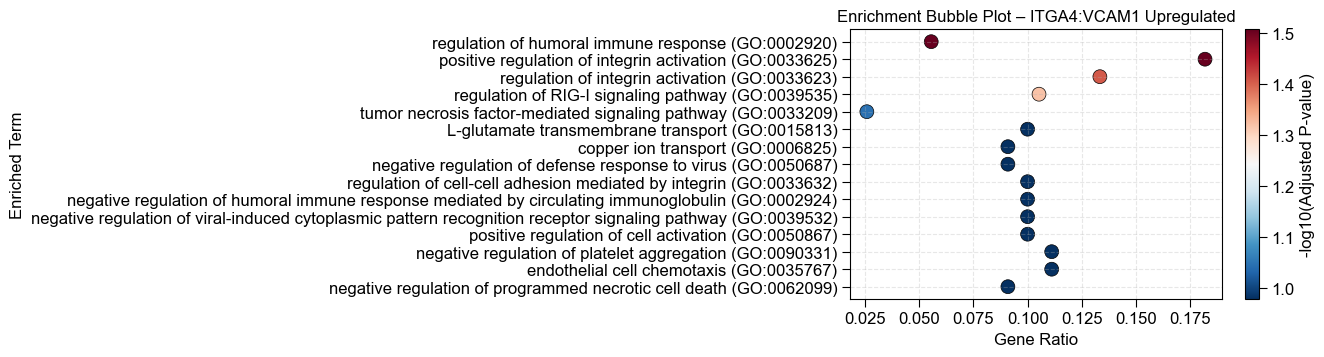

✅ Bubble plot saved to Figures/ITGA4_VCAM1_downregulated_GO.svg


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_37267/3704899393.py:119: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


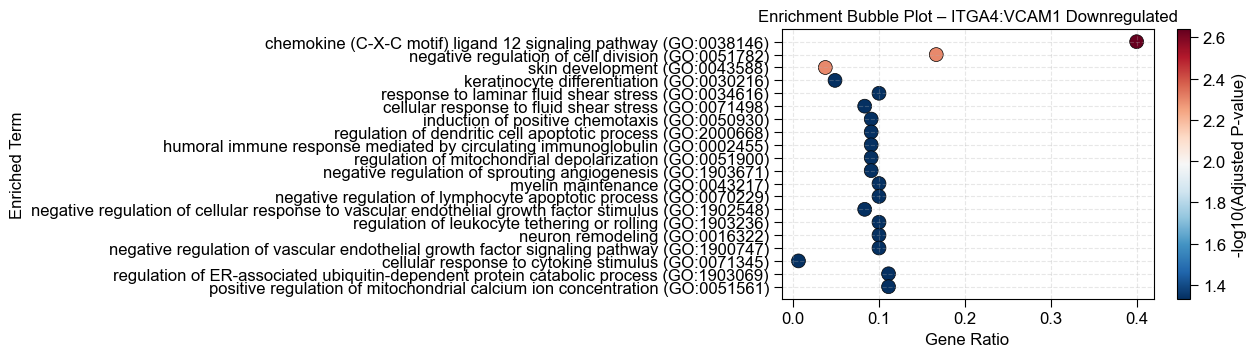

In [17]:
plot_enrichment_bubble(enrichment_results['Up'], label='ITGA4:VCAM1 Upregulated',top_n=15, save_path='Figures/Fig-6h.svg')
plot_enrichment_bubble(enrichment_results['Down'], label='ITGA4:VCAM1 Downregulated',save_path='Figures/ITGA4_VCAM1_downregulated_GO.svg')


In [14]:
def analyze_pla_volcano_from_raw(adata, target_protein, cluster1, cluster2,
                                  fc_thresh=1.0, pval_thresh=0.05,
                                  annotation_key="mrna_annotation", save_path=None):
    """
    Volcano plot comparing PLA pairs involving the target protein using raw data from AnnData.
    """
    import pandas as pd
    import numpy as np
    from scipy.stats import mannwhitneyu
    import matplotlib.pyplot as plt
    from adjustText import adjust_text

    # Convert raw to DataFrame
    raw_df = pd.DataFrame(
        adata.raw.X,
        columns=adata.raw.var_names,
        index=adata.obs_names
    )
    raw_df[annotation_key] = adata.obs[annotation_key].values

    # Filter PLA pairs that contain the target protein
    pla_cols = [col for col in raw_df.columns if target_protein in col and col != annotation_key]
    results = []

    for col in pla_cols:
        group1 = raw_df[raw_df[annotation_key] == cluster1][col]
        group2 = raw_df[raw_df[annotation_key] == cluster2][col]
        if len(group1) < 3 or len(group2) < 3:
            continue
        stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')
        mean1 = group1.mean()
        mean2 = group2.mean()
        log2fc = np.log2((mean1 + 1e-6) / (mean2 + 1e-6))
        results.append({'PLA_pair': col, 'log2FC': log2fc, 'pval': pval})

    volcano_df = pd.DataFrame(results)
    volcano_df['-log10(pval)'] = -np.log10(volcano_df['pval'])
    volcano_df['significant'] = (volcano_df['pval'] < pval_thresh) & (volcano_df['log2FC'].abs() > fc_thresh)

    # Plot
    plt.figure(figsize=(3, 3))
    texts = []
    for _, row in volcano_df.iterrows():
        color = 'red' if row['significant'] else 'gray'
        plt.scatter(row['log2FC'], row['-log10(pval)'], color=color, s=40)
        if row['significant']:
            texts.append(plt.text(row['log2FC'], row['-log10(pval)'], row['PLA_pair'],
                                  fontsize=8, color='black'))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

    plt.axhline(-np.log10(pval_thresh), linestyle='--', color='gray')
    plt.axvline(-fc_thresh, linestyle='--', color='gray')
    plt.axvline(fc_thresh, linestyle='--', color='gray')
    plt.xlabel(f'Log2 (Fold change)')
    plt.ylabel('-log10(p-value)')
    plt.title(f'{target_protein}-related protein pair')
    plt.tight_layout() 
    if save_path:
        plt.savefig(save_path, dpi=300)  # 
        print(f"✅ Volcano plot saved to {save_path}")
    else:
        plt.show()

    plt.show()


✅ Volcano plot saved to Figures/Fig-6e.svg


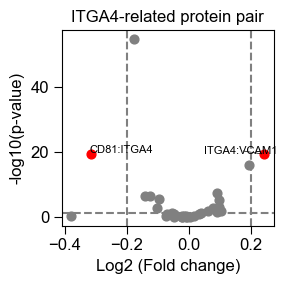

In [15]:
analyze_pla_volcano_from_raw(
    adata=adata_fraction_oeverlap_gc_follicle,
    target_protein='ITGA4',
    cluster1='Light zone',
    cluster2='Dark zone',
    fc_thresh=0.2,
    pval_thresh=0.05,
    save_path="Figures/Fig-6e.svg"
)
